# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

### Lab session recap : A.C.

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

___

### My global remarks :

There are some issues with the code / the subject :

 - I wanted to run it on my own computer, but since I don't have a Nvidia driver, the coda device is unusable. The easiest fix I could find was to change the device from GPU to CPU, even if it takes more computing time.

 - Unlike what was announced on the LeNet definition, the MNIST dataset doesn't give an input size of 32x32, but 28x28, thus changing the dimensions of the first full connection when using the flattening. I could either change the calculations to match the correct size of the MNIST dataset, or add a zero-padding to the images from the dataset so that they fit the LeNet description shown below. I decided to apply the second solution, because hopefully the second dataset $\underline{\text{cifar10}}$ will be the correct 32x32 size.

 So I added this line of code :

##### transform.append(T.Pad(2))

In the transform used to get the data and standardize it.

In [47]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

___

### My answer :

Since the size of kernels aren't written explicitely, we will do some calculations as to guess what their size are.
We will consider the stride to be 1, and the padding to be 0.

$$ \text{Output size}= \left\lfloor \dfrac{N+2P-K}{S} \right\rfloor + 1 $$

Since all the values are integers and $S = 1$,

$$ \text{Output size} = N-K + 1 $$

$$ K = N + 1 - \text{Output size} $$

In [48]:
# input channel = ?, output channels = ?, kernel size = ?, input image size = (?, ?), image output size = (?, ?)
# input dim = ? ( H x W x C), output dim = ?

class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    
    n_in_C1 = 1 #Number of channels in the input of the first convolutional layer
    n_out_C1 = 6 #Output of the first convolutional layer, we get C1 from the Input
    kernel_size_C1 = 5 #From the formula written above : 32 - 28 + 1 = 5

    self.C1 = torch.nn.Conv2d(n_in_C1, n_out_C1, kernel_size_C1)
    
    n_out_C3 = 16
    kernel_size_C3 = 5 #From the formula written above : 14 - 10 + 1 = 5
    
    self.C3 = torch.nn.Conv2d(n_out_C1,n_out_C3,kernel_size_C3)
    
    n_in_fc1 = 400 #We have S4 size being 16 @ 5x5 before flattening, which gives size = 16*5*5 = 400
    n_out_fc1 = 120
    n_out_fc2 = 84
    n_out_fc3 = 10
    self.fc1 = torch.nn.Linear(n_in_fc1,n_out_fc1)
    self.fc2 = torch.nn.Linear(n_out_fc1,n_out_fc2)
    self.fc3 = torch.nn.Linear(n_out_fc2,n_out_fc3)

  def forward(self, x):
    x = F.relu(self.C1(x)) #C1
    x = torch.nn.MaxPool2d(2,stride=2)(x) #S2
    x = F.relu(self.C3(x)) #C3
    x = torch.nn.MaxPool2d(2,stride=2)(x) #S4
    # flatten the feature maps into a long vector
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc1(x)) #C5
    x = F.relu(self.fc2(x)) #F6
    x = self.fc3(x) #Output
    return x

### Define cost function

In [49]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum

In [50]:
def get_optimizer(net, lr, wd, momentum):
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=wd)
  return optimizer

### Train and test functions

In [51]:
def test(net, data_loader, cost_function, device='cpu'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='cpu'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.


  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    # Reset the optimizer
    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***?

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\].

***How it can be done***?

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [52]:
def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  
  transform = list()
  transform.append(T.Pad(2)) #LINE ADDED BY ME to match the correct input image size 32x32
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)
  
  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [ ]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128,
         device='cpu',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50):
  train_loader, val_loader, test_loader = get_data(batch_size)

  # Defining LeNet-5 and moving it to the GPU
  net = LeNet()
  net.to(device)
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  
  return(net)

Lets train!

In [54]:
net = main()

Before training:
	 Training loss 0.01804, Training accuracy 10.44
	 Validation loss 0.00906, Validation accuracy 10.21
	 Test loss 0.00921, Test accuracy 11.24
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01031, Training accuracy 55.22
	 Validation loss 0.00084, Validation accuracy 93.73
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00122, Training accuracy 95.20
	 Validation loss 0.00045, Validation accuracy 96.56
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00074, Training accuracy 97.01
	 Validation loss 0.00040, Validation accuracy 96.85
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00058, Training accuracy 97.71
	 Validation loss 0.00034, Validation accuracy 97.34
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00046, Training accuracy 98.16
	 Validation loss 0.00033, Validation accuracy 97.41
---------------

Check which MNIST digit is most frequently confused with which other digit (e.g. plot a confusion matrix). Can you explain why?



___

#### My answer :

I found this code on this website :
https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

I adapted it to make it work on my end.

In [55]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

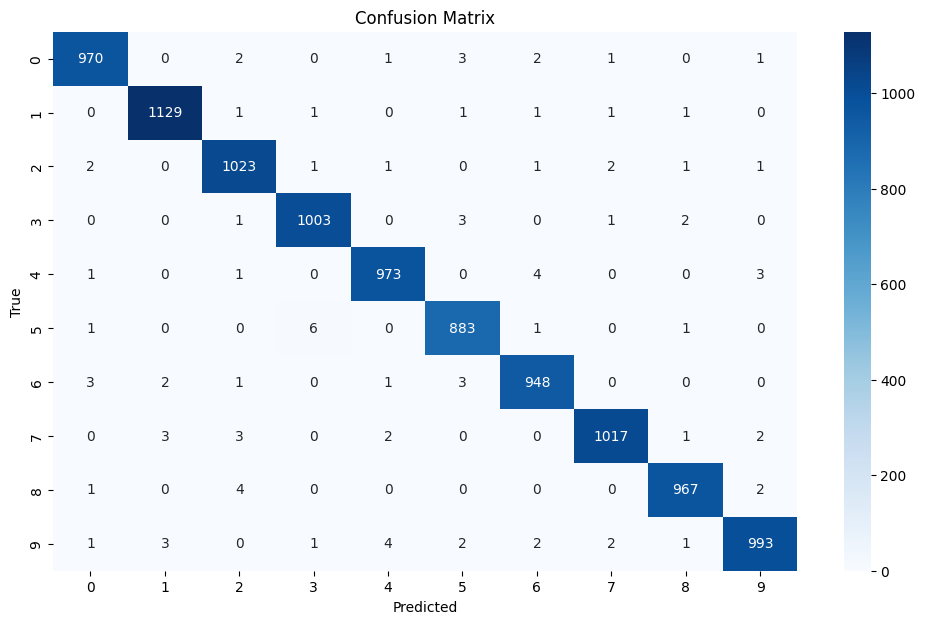

In [66]:
y_pred = []
y_true = []

train_loader, val_loader, test_loader = get_data(500)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to('cpu')
        outputs = net(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

classes = [i for i in range(10)]
cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

From this confusion matrix, we can see that the number 5 gets mistaken for the number 3 six times, which can be explained by the curve from the bottom part of the numbers.
9 and 4 also get mixed up because of the top part.
8 and 2 also get mixed, which is not that clear why, maybe because of the curvatures of some of the samples. Same for 4 and 6.

Overall, even if the model is overfitting the data (50 epochs for training is insanely high), it gets excellent results, with the mismatch rate being really low. 

___

The LeNet5 architecture can also be implemented using the sequential API ([see documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

##Experiments

* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch documentation to easily access the cifar10 dataset.
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.


___

First, we will implement early stopping. We will be using a parameter called $\underline{\text{stop value}}$ :

It represents the number of epoch used to compute an average of the validation error over the $k^{th}$ last epochs, with $k = \text{stop value}$, and comparing it to the $n-k$ validation error. It the average is inferior to the $(n-k)^{th}$ epoch, then we can continue training our model. If it is superior, then we have reached overfitting with the last $k$ epochs, thus stopping at the $(n-k)^{th}$ epoch.

In [84]:
def test_overfitting(validation_rates,stop_value):
  if len(validation_rates) >= stop_value + 1:
    if validation_rates[-stop_value-1] > max(validation_rates[-stop_value:]):
      return(True) #In this case the model is overfitting
  return(False) #We either don't have enough data, or the model isn't overfitting the data (yet)

def main_early_stopping(batch_size=128,
         device='cpu',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50,
         stop_value = 3):
  train_loader, val_loader, test_loader = get_data(batch_size)

  # TODO for defining LeNet-5 and moving it to the GPU
  net = LeNet()
  net.to(device)
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  
  validation_rates = [val_accuracy]
  
  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    test_loss, test_accuracy = test(net, test_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')
    validation_rates.append(val_accuracy)
    if test_overfitting(validation_rates,stop_value):
      print('\n\n Epoch: {:d} was the last epoch before the model started overfitting'.format(e+1-stop_value))
      break
  return(net)

Let's test it :

In [86]:
net_early_stopping = main_early_stopping()

Before training:
	 Training loss 0.01807, Training accuracy 8.94
	 Validation loss 0.00907, Validation accuracy 8.91
	 Test loss 0.00923, Test accuracy 8.81
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01060, Training accuracy 54.82
	 Validation loss 0.00089, Validation accuracy 93.07
	 Test loss 0.00077, Test accuracy 93.97
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00120, Training accuracy 95.19
	 Validation loss 0.00042, Validation accuracy 96.77
	 Test loss 0.00035, Test accuracy 97.11
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00072, Training accuracy 97.13
	 Validation loss 0.00034, Validation accuracy 97.29
	 Test loss 0.00029, Test accuracy 97.70
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00055, Training accuracy 97.72
	 Validation loss 0.00028, Validation accuracy 97.80
	 Test loss 0.00022, Test accuracy 98.09
-------------------

We compute its confusion matrix : 

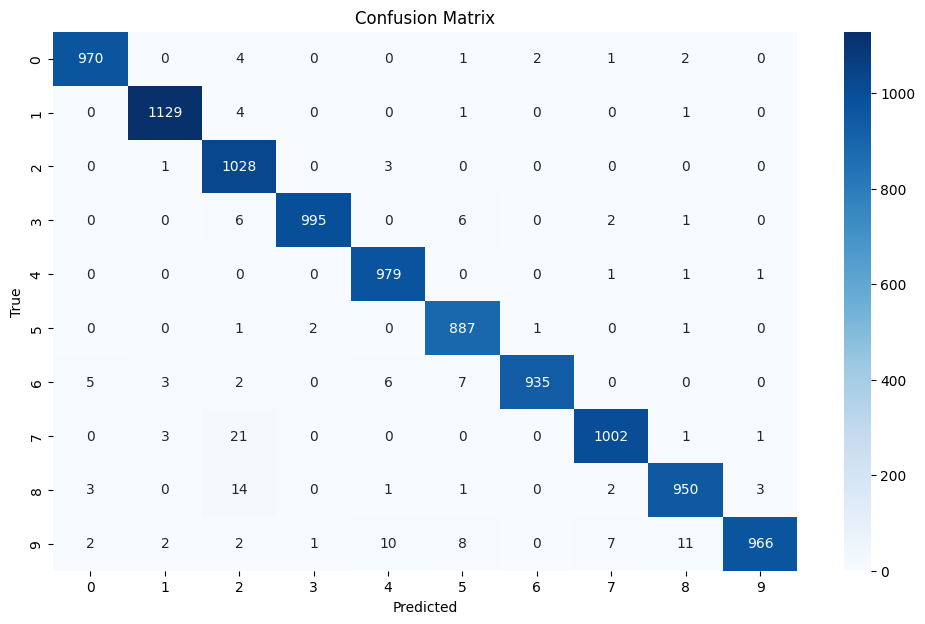

In [87]:
y_pred = []
y_true = []

train_loader, val_loader, test_loader = get_data(500)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to('cpu')
        outputs = net_early_stopping(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

classes = [i for i in range(10)]
cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

With early stopping, we avoid overfitting, however we get more confusions between 7 and 2, 8 and 2, 9 and 4 (as before), and now 6 and 5, 9 and 7, and finally 9 and 8.

Those errors are still really sparse compared to the results obtained in the diagonals.
___

Let's show random samples for both the net and the net_early_stopping :

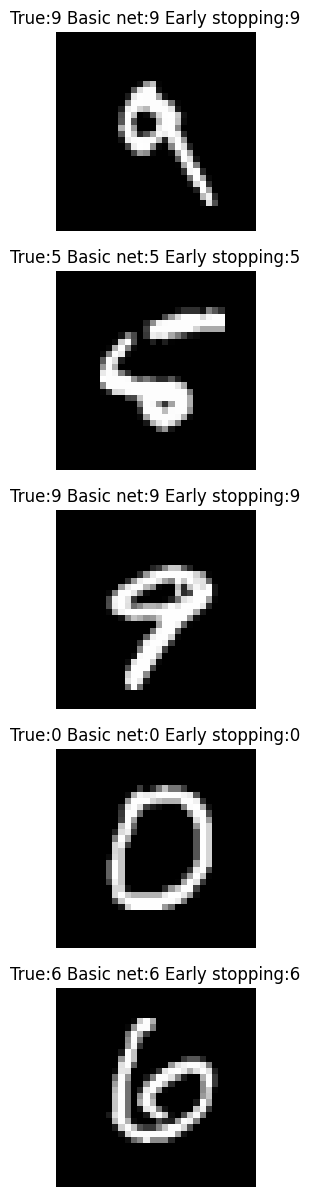

In [101]:
train_loader, val_loader, test_loader = get_data(500)
n = np.random.randint(0,len(test_loader)-5)

f, ax = plt.subplots(5,1, figsize=(5,15))
with torch.no_grad():
    for i, idx in enumerate(range(n,n+5)):
        img, label = test_loader.dataset[idx]
        input_tensor = img.unsqueeze(0).to('cpu')
        prediction_basic_net = net(input_tensor).argmax(1).item()
        prediction_net_early_stopping = net_early_stopping(input_tensor).argmax(1).item()

        img_np = img.squeeze().numpy()
        if img_np.ndim == 3:
            img_np = np.transpose(img_np, (1, 2, 0))

        ax[i].imshow(img_np, cmap='gray' if img_np.ndim == 2 else None)
        ax[i].set_title(f"True:{label} Basic net:{prediction_basic_net} Early stopping:{prediction_net_early_stopping}")
        ax[i].axis('off')

plt.show()

Even with images that are really curved, both the 50 epochs-trained net and the early-stopped net (11 epochs before recognizing a potential overfitting) identify correctly the numbers.

___

Now let's try to implement the cifar10 dataset, which contains images of vehicles (airplane, ship, truck, automobile) and animals. We need to change the number of channels in the input since we have R,G,B instead if just gray scale.

In [106]:
class LeNet_cifar10(torch.nn.Module):
  def __init__(self):
    super(LeNet_cifar10, self).__init__()
    
    n_in_C1 = 3 #Number of channels in the input of the first convolutional layer
    n_out_C1 = 6 #Output of the first convolutional layer, we get C1 from the Input
    kernel_size_C1 = 5 #From the formula written above : 32 - 28 + 1 = 5

    self.C1 = torch.nn.Conv2d(n_in_C1, n_out_C1, kernel_size_C1)
    
    n_out_C3 = 16
    kernel_size_C3 = 5 #From the formula written above : 14 - 10 + 1 = 5
    
    self.C3 = torch.nn.Conv2d(n_out_C1,n_out_C3,kernel_size_C3)
    
    n_in_fc1 = 400 #We have S4 size being 16 @ 5x5 before flattening, which gives size = 16*5*5 = 400
    n_out_fc1 = 120
    n_out_fc2 = 84
    n_out_fc3 = 10
    self.fc1 = torch.nn.Linear(n_in_fc1,n_out_fc1)
    self.fc2 = torch.nn.Linear(n_out_fc1,n_out_fc2)
    self.fc3 = torch.nn.Linear(n_out_fc2,n_out_fc3)

  def forward(self, x):
    x = F.relu(self.C1(x)) #C1
    x = torch.nn.MaxPool2d(2,stride=2)(x) #S2
    x = F.relu(self.C3(x)) #C3
    x = torch.nn.MaxPool2d(2,stride=2)(x) #S4
    # flatten the feature maps into a long vector
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc1(x)) #C5
    x = F.relu(self.fc2(x)) #F6
    x = self.fc3(x) #Output
    return x

In [114]:
def get_data_cifar10(batch_size, test_batch_size = 256):
  transform = list()
  transform.append(T.ToTensor())
  transform.append(T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]))      #Normalization for cifar10
  transform = T.Compose(transform)
  
  # Load data
  full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)

  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader    

def main_cifar10(batch_size=128,
         device='cpu',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50):
  train_loader, val_loader, test_loader = get_data_cifar10(batch_size)

  # TODO for defining LeNet-5 and moving it to the GPU
  net = LeNet_cifar10()
  net.to(device)
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  
  return(net)

In [115]:
cifar10_net = main_cifar10()

Before training:
	 Training loss 0.01806, Training accuracy 9.51
	 Validation loss 0.00903, Validation accuracy 9.82
	 Test loss 0.00921, Test accuracy 9.23
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01680, Training accuracy 19.16
	 Validation loss 0.00730, Validation accuracy 32.65
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01307, Training accuracy 39.47
	 Validation loss 0.00604, Validation accuracy 43.94
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01162, Training accuracy 46.09
	 Validation loss 0.00593, Validation accuracy 45.07
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01081, Training accuracy 50.11
	 Validation loss 0.00541, Validation accuracy 50.09
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01014, Training accuracy 53.54
	 Validation loss 0.00533, Validation accuracy 51.29
------------------

We now plot the confusion matrix :

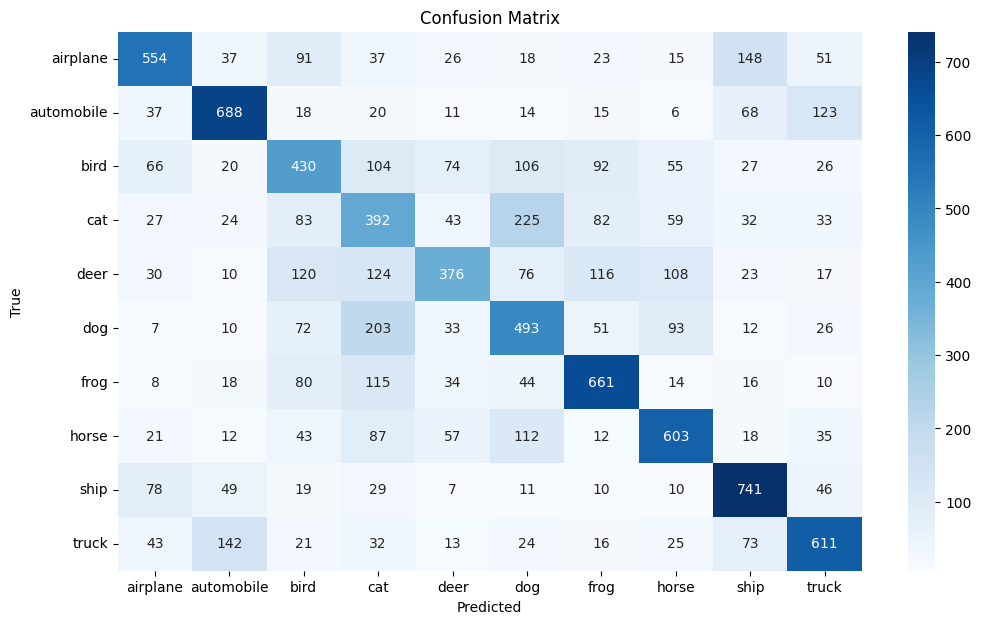

In [116]:
y_pred = []
y_true = []
train_loader, val_loader, test_loader = get_data_cifar10(500)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to('cpu')
        outputs = cifar10_net(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
df_cm = pd.DataFrame(cf_matrix, index=cifar10_classes, columns=cifar10_classes)

plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

The net overfits the data : It can be seen because of the validation accuracy recessing from its best values to lower ones.
We can see that the model mistakenly matches automobile and truck (which is not that bad), same for cats and dogs, and overall all animals. Transports are mostly being correctly identified, same for frog and horses.

The worse matches are for birds, cats, deers and dogs.
___

Now let's look at some random images, to see it the trained net on the cifar10 dataset identifies correctly the different images :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4810324..1.5034215].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9257283..1.9332287].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4814163..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7989522..2.0108907].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.9815438].


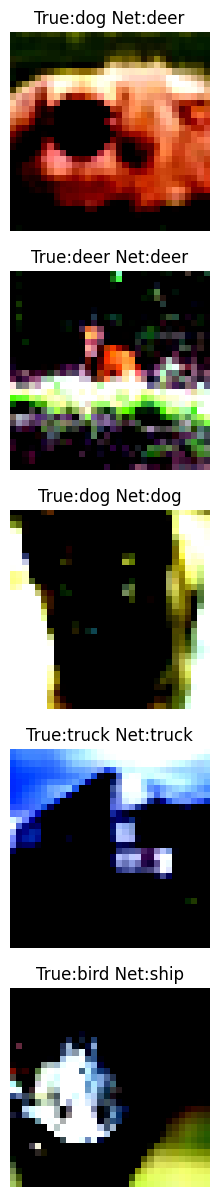

In [128]:
train_loader, val_loader, test_loader = get_data_cifar10(1000)
n = np.random.randint(0,len(test_loader)-5)

f, ax = plt.subplots(5,1, figsize=(5,15))
with torch.no_grad():
    for i, idx in enumerate(range(n,n+5)):
        img, label = test_loader.dataset[idx]
        input_tensor = img.unsqueeze(0).to('cpu')
        prediction = cifar10_net(input_tensor).argmax(1).item()

        img_np = img.squeeze().numpy()
        if img_np.ndim == 3:
            img_np = np.transpose(img_np, (1, 2, 0))

        ax[i].imshow(img_np, cmap='gray' if img_np.ndim == 2 else None)
        ax[i].set_title(f"True:{cifar10_classes[label]} Net:{cifar10_classes[prediction]}")
        ax[i].axis('off')

plt.show()

Honeslty the images are horrible. With a resolution like this, no wonder the nets has such high errors with the validation set. For the mismatched images, it would have been impossible even for me to say if it were a dog or a frog or something else entirely.

Let's implement the cifar10 dataset with early stopping (choosing 15 epochs seems to be a great choice according to our last computation) :

In [118]:
cifar10_net_early_stopping = main_cifar10(epochs=15)

Before training:
	 Training loss 0.01807, Training accuracy 9.29
	 Validation loss 0.00903, Validation accuracy 9.37
	 Test loss 0.00921, Test accuracy 9.08
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01642, Training accuracy 22.91
	 Validation loss 0.00727, Validation accuracy 31.99
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01332, Training accuracy 37.95
	 Validation loss 0.00602, Validation accuracy 43.85
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01173, Training accuracy 45.78
	 Validation loss 0.00581, Validation accuracy 46.93
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01081, Training accuracy 50.85
	 Validation loss 0.00549, Validation accuracy 50.54
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01014, Training accuracy 53.69
	 Validation loss 0.00503, Validation accuracy 54.23
------------------

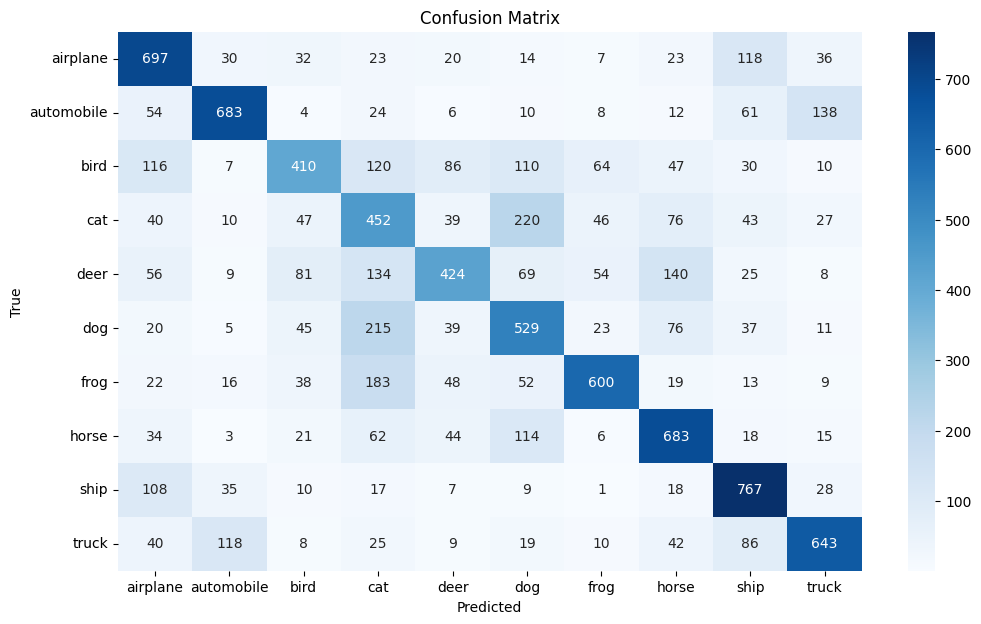

In [119]:
y_pred = []
y_true = []
train_loader, val_loader, test_loader = get_data_cifar10(500)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to('cpu')
        outputs = cifar10_net_early_stopping(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
df_cm = pd.DataFrame(cf_matrix, index=cifar10_classes, columns=cifar10_classes)

plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Previoulsy, the worse value was 376 for the correct guesses of a deer, which climbed up to 424 now, which is quite good. We can show some images again :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7226075..2.0620687].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6581874..2.055863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5925539..1.4862162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8836575..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8353425..1.2811464].


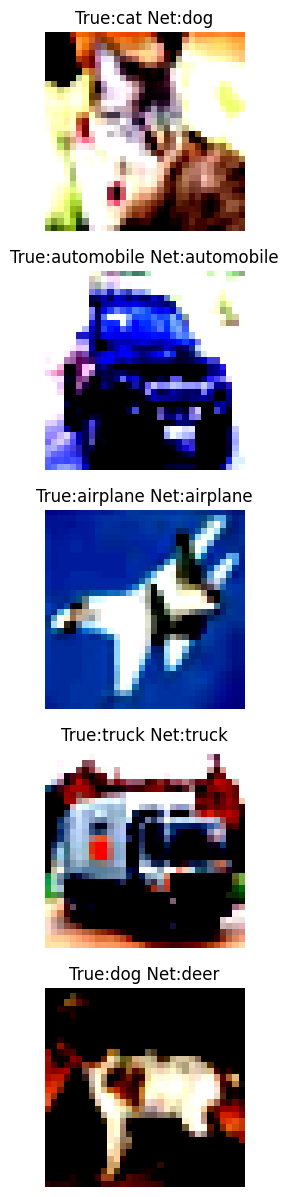

In [134]:
train_loader, val_loader, test_loader = get_data_cifar10(500)
n = np.random.randint(0,len(test_loader)-5)

f, ax = plt.subplots(5,1, figsize=(5,15))
with torch.no_grad():
    for i, idx in enumerate(range(n,n+5)):
        img, label = test_loader.dataset[idx]
        input_tensor = img.unsqueeze(0).to('cpu')
        prediction = cifar10_net_early_stopping(input_tensor).argmax(1).item()

        img_np = img.squeeze().numpy()
        if img_np.ndim == 3:
            img_np = np.transpose(img_np, (1, 2, 0))

        ax[i].imshow(img_np, cmap='gray' if img_np.ndim == 2 else None)
        ax[i].set_title(f"True:{cifar10_classes[label]} Net:{cifar10_classes[prediction]}")
        ax[i].axis('off')

plt.show()

The Net is quite good, but If the data is being shuffled a bit we sometimes encounter some completely wrong guess. Overall it works fine.

___

Since the cifar10 datasets has the worse results over the MNIST datasets, we will be implementing the data augmentation and dropout on this dataset to try to imporve the results.

Now we will be implementing data augmentation and dropout. We will be using $p = 0.2$ for dropout, since we don't want the last layers to dropout too often.

In [135]:
class LeNet_cifar10_dropout(torch.nn.Module):
  def __init__(self):
    super(LeNet_cifar10_dropout, self).__init__()
    n_in_C1 = 3
    n_out_C1 = 6
    kernel_size_C1 = 5
    self.C1 = torch.nn.Conv2d(n_in_C1, n_out_C1, kernel_size_C1)
    n_out_C3 = 16
    kernel_size_C3 = 5
    self.C3 = torch.nn.Conv2d(n_out_C1,n_out_C3,kernel_size_C3)
    n_in_fc1 = 400
    n_out_fc1 = 120
    n_out_fc2 = 84
    n_out_fc3 = 10
    self.fc1 = torch.nn.Linear(n_in_fc1,n_out_fc1)
    self.fc2 = torch.nn.Linear(n_out_fc1,n_out_fc2)
    self.fc3 = torch.nn.Linear(n_out_fc2,n_out_fc3)
    
    self.dropout = torch.nn.Dropout(p=0.2) #Dropout added
    
  def forward(self, x):
    x = F.relu(self.C1(x))
    x = torch.nn.MaxPool2d(2,stride=2)(x)
    x = F.relu(self.C3(x))
    x = torch.nn.MaxPool2d(2,stride=2)(x)
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    
    x = self.dropout(x) #Dropout added
    
    x = F.relu(self.fc2(x))
    
    x = self.dropout(x) #Dropout added
    
    x = self.fc3(x)
    return x

We also apply data augmentation, with a random horizontal flip of probability p = 0.5, and random crop with 2 padding (removing 2 pixel on each side of the images, the center of the image should still be recognizable) :

In [136]:
def get_data_cifar10_augmented(batch_size, test_batch_size = 256):
  train_transform = list()
  train_transform.append(T.RandomHorizontalFlip(p=0.5))
  train_transform.append(T.RandomCrop(32, padding=2))
  train_transform.append(T.ToTensor())
  train_transform.append(T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]))      #Normalization for cifar10
  train_transform = T.Compose(train_transform)

  test_transform = list()
  test_transform.append(T.ToTensor())
  test_transform.append(T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]))
  test_transform = T.Compose(test_transform)

  
  # Load data
  full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=train_transform, download=True)
  test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=test_transform, download=True)

  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader    

def main_cifar10_dropout_augmented(batch_size=128,
         device='cpu',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50):
  train_loader, val_loader, test_loader = get_data_cifar10_augmented(batch_size)

  # TODO for defining LeNet-5 and moving it to the GPU
  net = LeNet_cifar10_dropout()
  net.to(device)
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  
  return(net)

In [141]:
cifar10_dropout_augmented_net = main_cifar10_dropout_augmented(epochs = 35)

Before training:
	 Training loss 0.01807, Training accuracy 9.76
	 Validation loss 0.00904, Validation accuracy 10.02
	 Test loss 0.00922, Test accuracy 9.91
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01722, Training accuracy 17.83
	 Validation loss 0.00772, Validation accuracy 27.18
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01460, Training accuracy 31.61
	 Validation loss 0.00665, Validation accuracy 37.35
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01314, Training accuracy 38.72
	 Validation loss 0.00613, Validation accuracy 42.38
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01229, Training accuracy 43.27
	 Validation loss 0.00587, Validation accuracy 45.00
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01170, Training accuracy 45.80
	 Validation loss 0.00552, Validation accuracy 48.85
-----------------

Let's plot the confusion matrix :

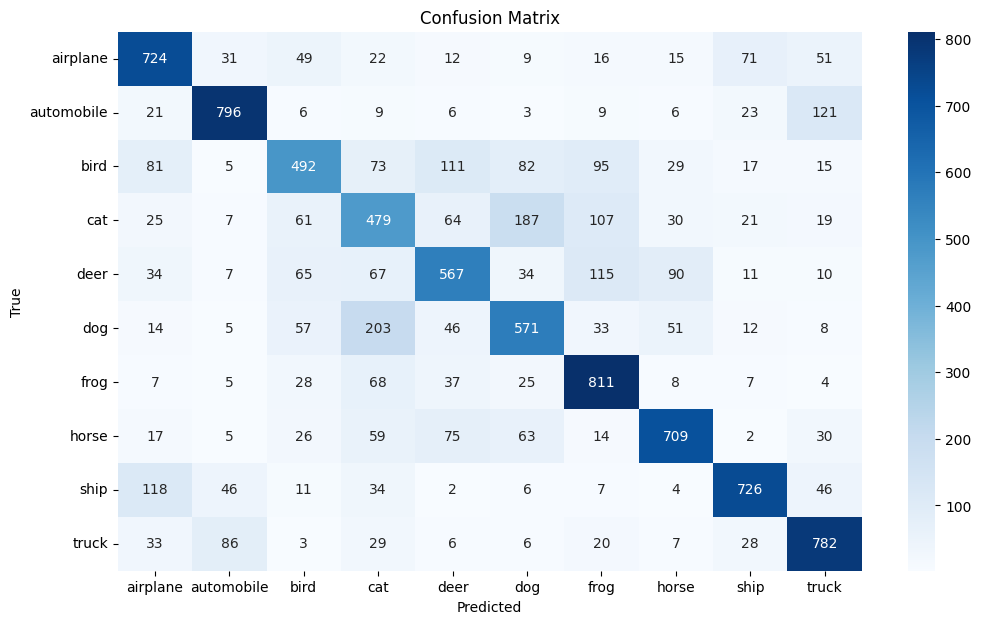

In [142]:
y_pred = []
y_true = []
train_loader, val_loader, test_loader = get_data_cifar10_augmented(500)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to('cpu')
        outputs = cifar10_dropout_augmented_net(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
df_cm = pd.DataFrame(cf_matrix, index=cifar10_classes, columns=cifar10_classes)

plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

We see that the diagonals are all better, dogs and cats are still being mistakenly switched ; same for automobiles and trucks. The results are good otherwise. 

Let's look at some images and the guesses of our Net using dropout and data augmentation :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9641825..0.99536407].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4810324..1.5034215].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9257283..1.9332287].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4814163..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7989522..2.0108907].


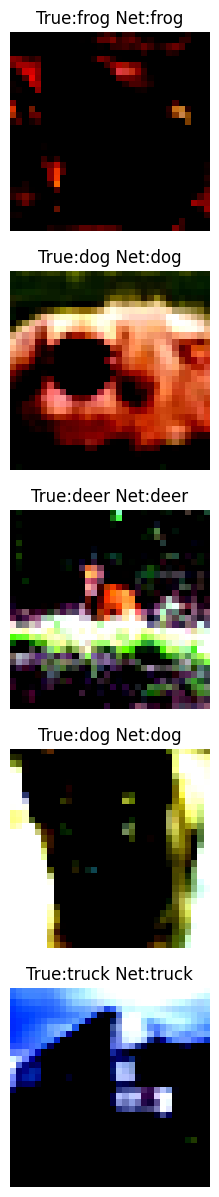

In [143]:
train_loader, val_loader, test_loader = get_data_cifar10_augmented(500)
n = np.random.randint(0,len(test_loader)-5)

f, ax = plt.subplots(5,1, figsize=(5,15))
with torch.no_grad():
    for i, idx in enumerate(range(n,n+5)):
        img, label = test_loader.dataset[idx]
        input_tensor = img.unsqueeze(0).to('cpu')
        prediction = cifar10_dropout_augmented_net(input_tensor).argmax(1).item()

        img_np = img.squeeze().numpy()
        if img_np.ndim == 3:
            img_np = np.transpose(img_np, (1, 2, 0))

        ax[i].imshow(img_np, cmap='gray' if img_np.ndim == 2 else None)
        ax[i].set_title(f"True:{cifar10_classes[label]} Net:{cifar10_classes[prediction]}")
        ax[i].axis('off')

plt.show()

We can see that the images are overall all correct when we shuffle them a bit. Dropout and data augmentation had a real impact on the results obtained by our model, compared to just training and overfitting our model as seen before.

___

I've heard from some friends that Resnet takes a huge amount of training time even on Google Collab, doing it locally would just be impossible. I'll stick to the results I get here.

## End of recap